In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set(font_scale=1.2)
sns.set_style('whitegrid')
#%matplotlib inline

In [3]:
model_testing = 'y'
data_checks = 'n' # y -> visualize data and correlation plots (it takes a while to execute the merged pairplot)
# preproc_log = 'n' # se lo accendo non impara più nulla, con lo Z invece funziona
remove_outliers = True

## TRAINING
nepochs = 100
# choosen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
choosen_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# we use "Sparse" because classes aren't represented with one hot encoding ie (0,1) e (1,0) but with integers 0 e 1
# choosen_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
choosen_loss = 'sparse_categorical_crossentropy'
 
activation = 'sigmoid'

# hyperparameters: learning_rate, batch_size, 
# choice of the optimizer (algorithm)

# Dataset W -> e + nu
Run number of the event, Event number, pt eta phi are the electron's kinematics variables, Q is electron's charge, type is where they found the electron (in the barrel or the endcap), the del- features and sigmaEtaEta are the differences between the track variable and the one of the cluster, HoverE is the ratio of the electron's energy measured HCAL/ECAL, iso are parameters associated to electron detection, MET features refer to the kinematics of the neutrino

In [30]:
dfenu_raw = pd.read_csv('~/Documents/tesi/thesis_notebooks/input_datasets/Wenu.csv')
dfenu_raw['type'] = dfenu_raw['type'].map({'EB': 0, 'EE': 1})

In [31]:
# to uniform datasets
dfenu_raw['iso'] = dfenu_raw.apply(lambda x: x['isoTrack'] + x['isoEcal'] + x['isoHcal'],axis=1)

In [32]:
dfenu_raw = dfenu_raw[['pt', 'eta', 'phi', 'MET', 'phiMET']]

## Data visualization (W -> e + nu)
We will introduce `dfenu_scaled` (numpy array) and `dfenu_array_to_dfenu` (pandas dataframe) for the visualization WITH OUTLIERS, while `dfenu_filtered` and `dfenu_scaled_filtered` are for the visualization WITHOUT OUTLIERS

In [33]:
if data_checks=='y':
    # aesthetics
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    # boxplot
    sns.boxplot(data=dfenu_raw, orient="h", whis=1.5)

**Boxplot comment**: `pt` e `MET` are the only ones that present *outliers* between the features of interest.

**The coloured rectangle covers the range 25-75 percentile, while the whiskers reach to 1.5 times the distance between 25-75th percentile in both directions (starting from the median)**

## Removing outliers

In [34]:
#dfe = dfenu_raw[['pt','eta','phi','Q','iso','MET','phiMET']]
dfe = dfenu_raw

if remove_outliers:
#   cutoff_pt_e = dfe['pt'].quantile(.95)
#   cutoff_MET_e = dfe['MET'].quantile(.95)
    cutoff_pt_e = 260
    cutoff_MET_e = 100
    dfe = dfe[(dfe['pt']<cutoff_pt_e) & (dfe['MET']<cutoff_MET_e)]
    
    print(f"Total number of data points:\t\t{len(dfenu_raw)}")
    # for troubleshooting
    # excluded_e = dfenu_array_to_dfenu[(dfenu_array_to_dfenu['pt']>cutoff_scal_pt_e) | (dfenu_array_to_dfenu['MET']>cutoff_scal_MET_e)]
    print(f"Data points after filtering outliers:\t {len(dfe)}")

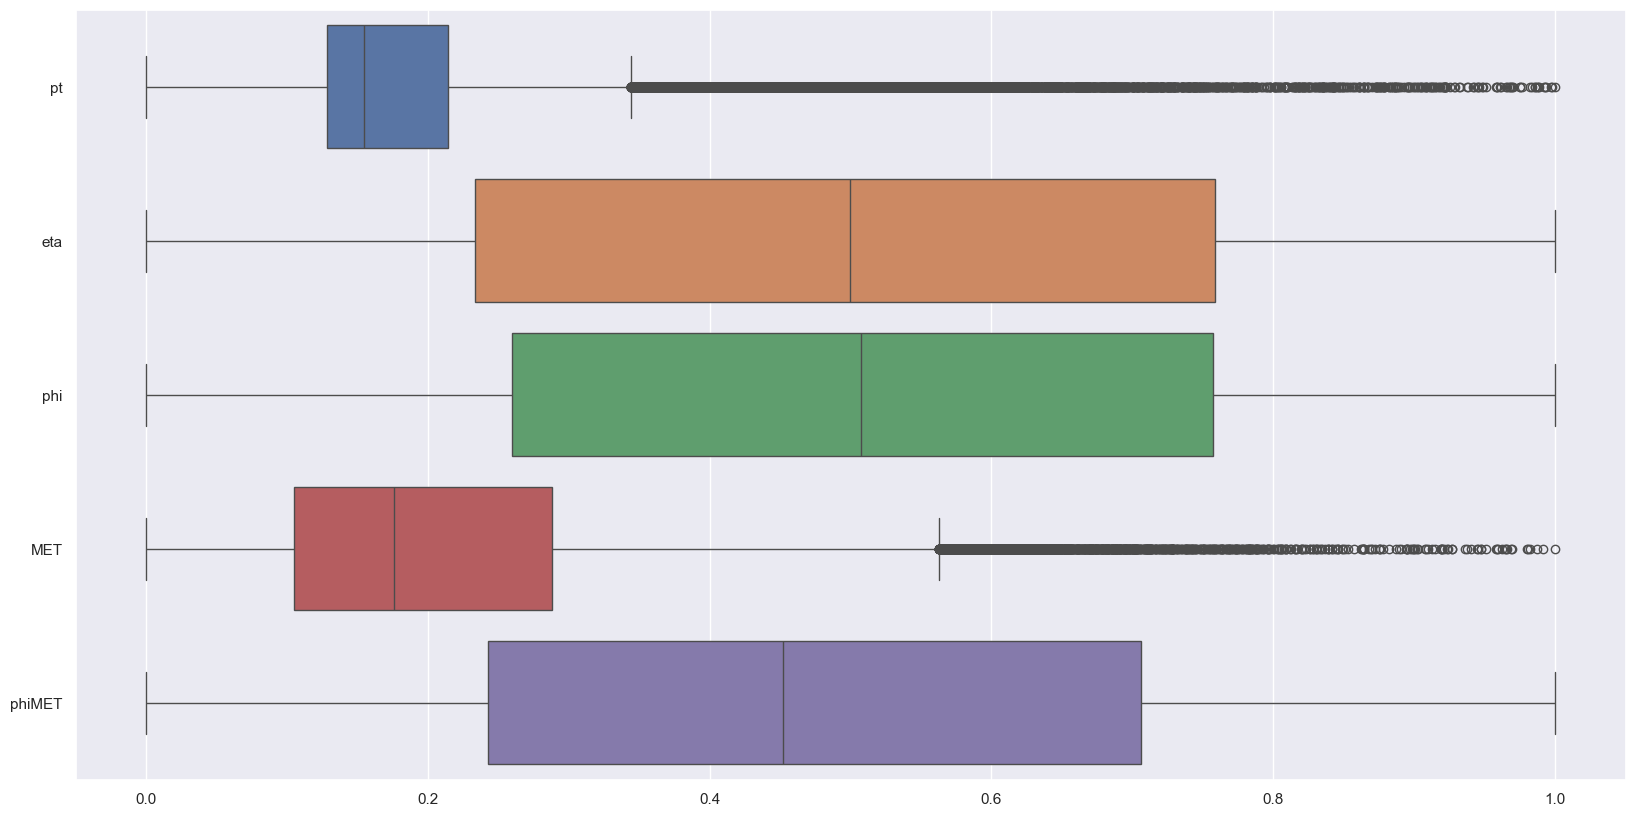

In [14]:
if data_checks=='y':
# for a uniform visualization, linearly scaling the data between 0 and 1
    scaler = preprocessing.MinMaxScaler()
    dfenu_scaled = scaler.fit_transform(dfe)
    dfe_array_to_df = pd.DataFrame(dfenu_scaled, columns = dfenu_raw.columns)
    # aesthetics
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    # boxplot
    sns.boxplot(data=dfe_array_to_df, orient="h", whis=1.5)

**NEW boxplot comment**: pt still shows data points out of the whiskers but due to their number, the results of the training, and the sake of keeping as much data as possible they will be kept and considered throughout the analysis

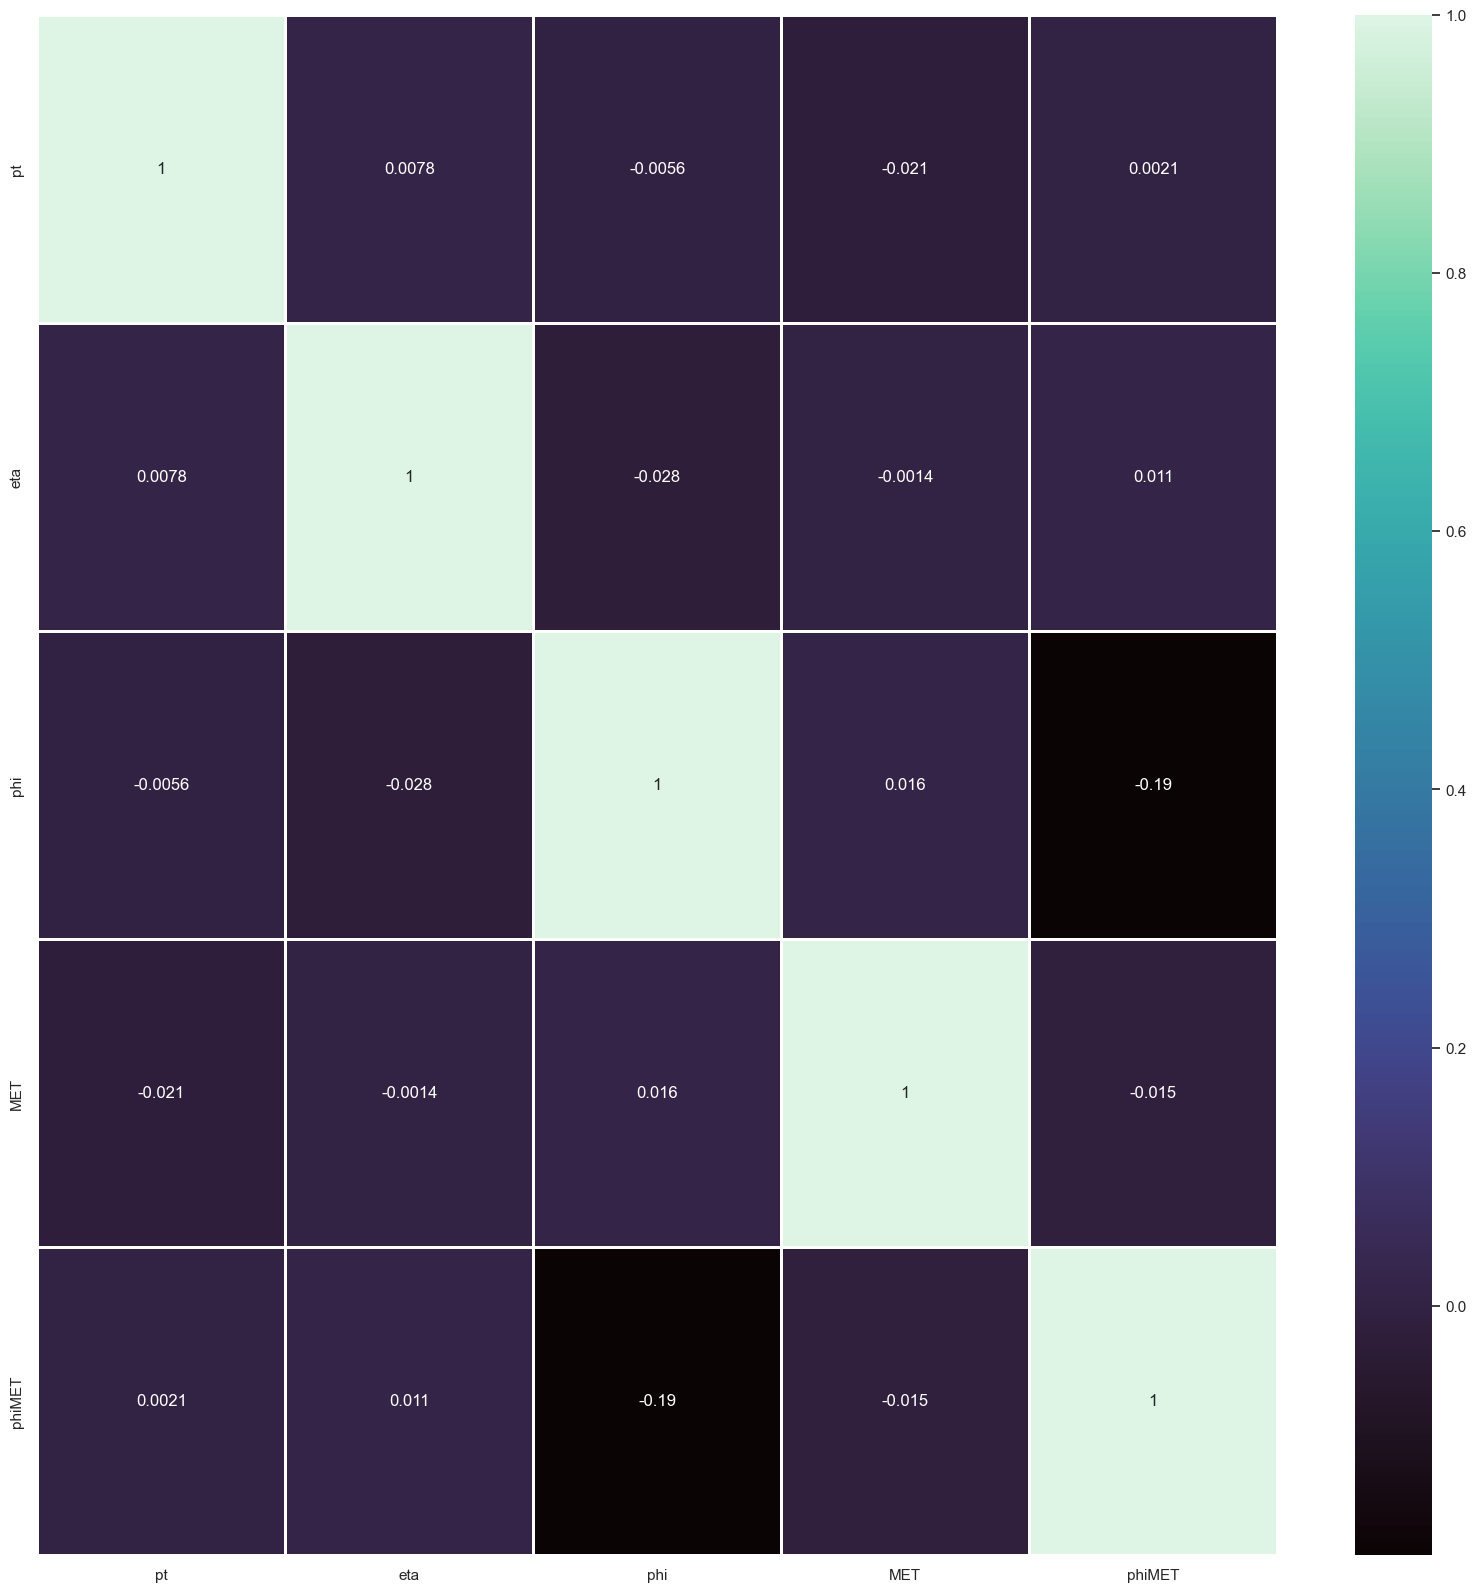

In [8]:
if data_checks=='y':
    fig, ax = plt.subplots(figsize=(20,20))
    # sns.set(font_scale=1.0)
    sns.heatmap(dfe_array_to_df.corr() , annot= True, linewidths=2, ax=ax, cmap='mako')

<Figure size 2000x1000 with 0 Axes>

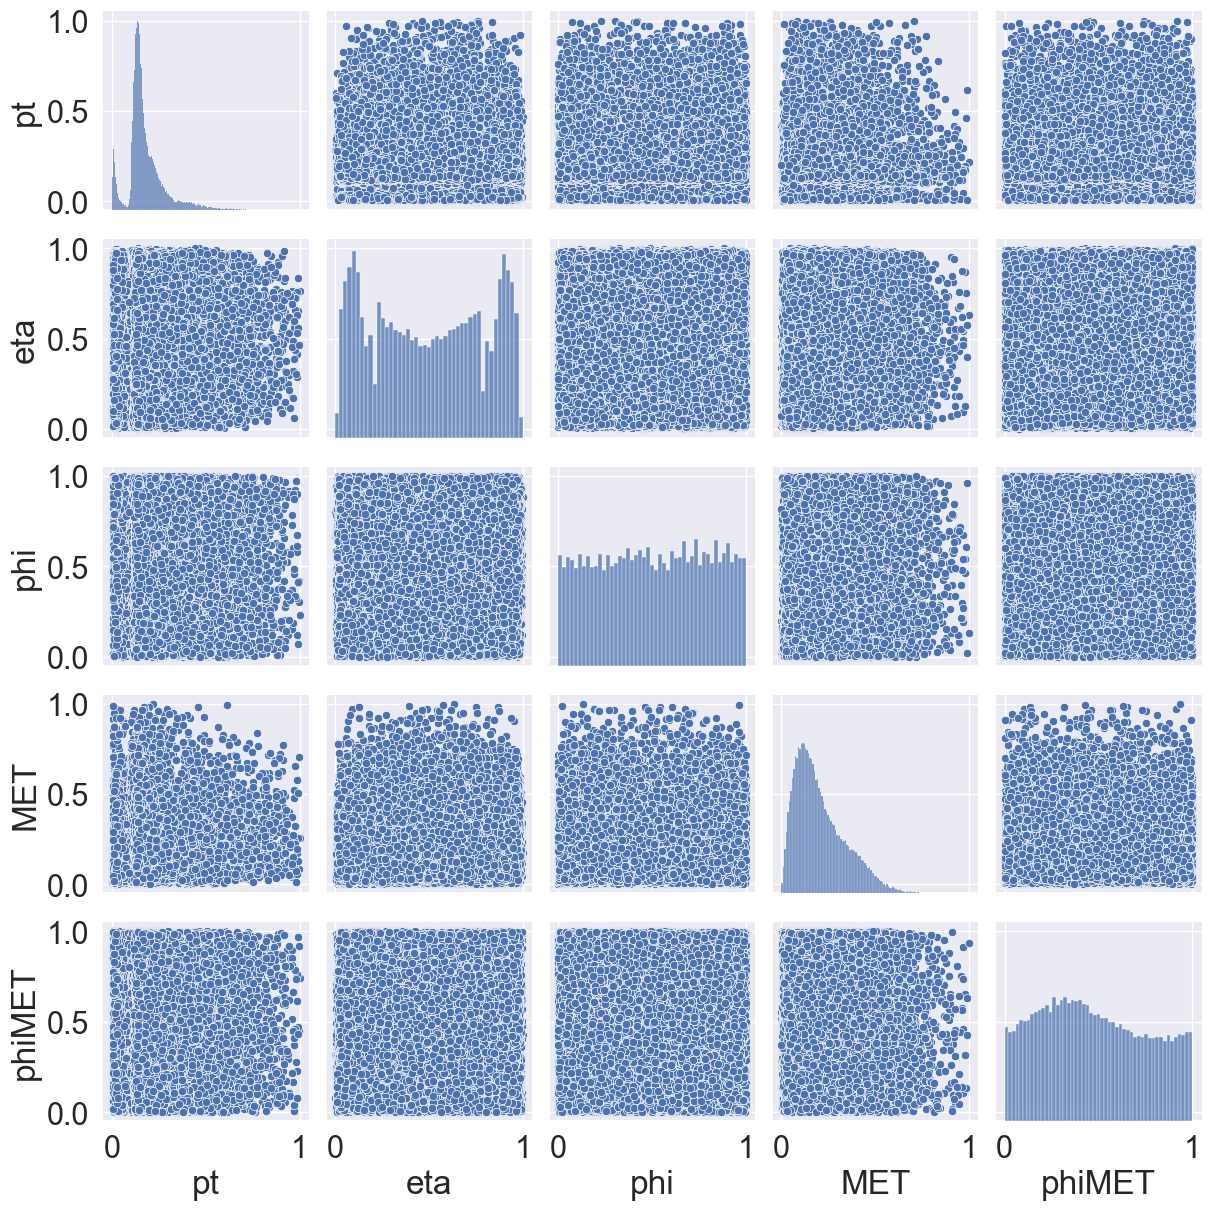

In [15]:
# Checking for higher order correlations (this will be repeated after merging the 2 different datasets)
if data_checks=='y':
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    fig_pairplot_e = sns.pairplot(dfe_array_to_df) # diag_kind='kde'

In [16]:
#fig_pairplot_e.savefig('pairplot_enu.png')

**Pairplot comment**: the features don't exhibit evident patters, they all seem to carry independent information

In [36]:
# Adding 'class' because of dataset merging 
class_col = []
for i in range(len(dfe['pt'])):
    class_col.append('enu')
    
dfe.loc[:,'class'] = class_col

# Dataset W -> mu + nu
**Feature comment**: `chisq` is divided by dof, the kinematics features come from fits on data so chisq abnormally high should just be left out of the training of the network, because even if they were decay events they exhibit a peculiar behaviour (like outliers) and the network is not designed to take care of such fine phenomena, `dxy` is the impact parameter, the `iso` parameter represents the threshold for the cluster to be identifyed as the trace/sign of an muon 

In [4]:
dfmunu_raw = pd.read_csv('~/Documents/tesi/thesis_notebooks/input_datasets/Wmunu.csv')

Let's get rid of the events with an high chisq

In [5]:
chisq_th = 10 # threshold for acceptance of the data. It is a reduced chi squared!
not_trustworthy = dfmunu_raw[dfmunu_raw['chiSq'] > chisq_th]
dfmunu_raw.drop(not_trustworthy.index, inplace=True)
len(not_trustworthy)

4802

In [6]:
# keep only features of interest
dfmunu_raw = dfmunu_raw[['pt', 'phi', 'eta', 'MET', 'phiMET']]

## Data visualization (W -> mu + nu)

We will introduce `dfmunu_scaled` (numpy array) and `dfmunu_array_to_dfenu` (pandas dataframe) for the visualization WITH OUTLIERS, while `dfmunu_filtered` and `dfmunu_scaled_filtered` are for the visualization WITHOUT OUTLIERS

## Removing outliers

In [7]:
# again in preparation for future merging
dfmu = dfmunu_raw[['pt','eta','phi','MET','phiMET']]

if remove_outliers:
#   cutoff_pt_mu = dfmunu_raw['pt'].quantile(.95)
#   cutoff_MET_mu = dfmunu_raw['MET'].quantile(.95)
    cutoff_pt_mu = 170
    cutoff_MET_mu = 155
    dfmu = dfmu[(dfmu['pt']<cutoff_pt_mu) & (dfmu['MET']<cutoff_MET_mu)]
    print(f"Total number of data points:\t\t{len(dfmunu_raw)}")
    print(f"Data points after filtering outliers:\t{len(dfmu)} ({len(dfmu)/len(dfmunu_raw)*100:2.2f}%)")

**Boxplot comment**: `pt` and `MET` are the only relevant features that exhibit outliers

In [7]:
if data_checks=='y':
    scaler = preprocessing.MinMaxScaler()
    dfmunu_scaled = scaler.fit_transform(dfmu)
    dfmu_array_to_df = pd.DataFrame(dfmunu_scaled, columns = dfmunu_raw.columns)
    # aesthetics
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    # boxplot
    sns.boxplot(data=dfmu_array_to_df, orient="h")

**Boxplot comment**: `pt` and `MET` are the only relevant features that exhibit outliers

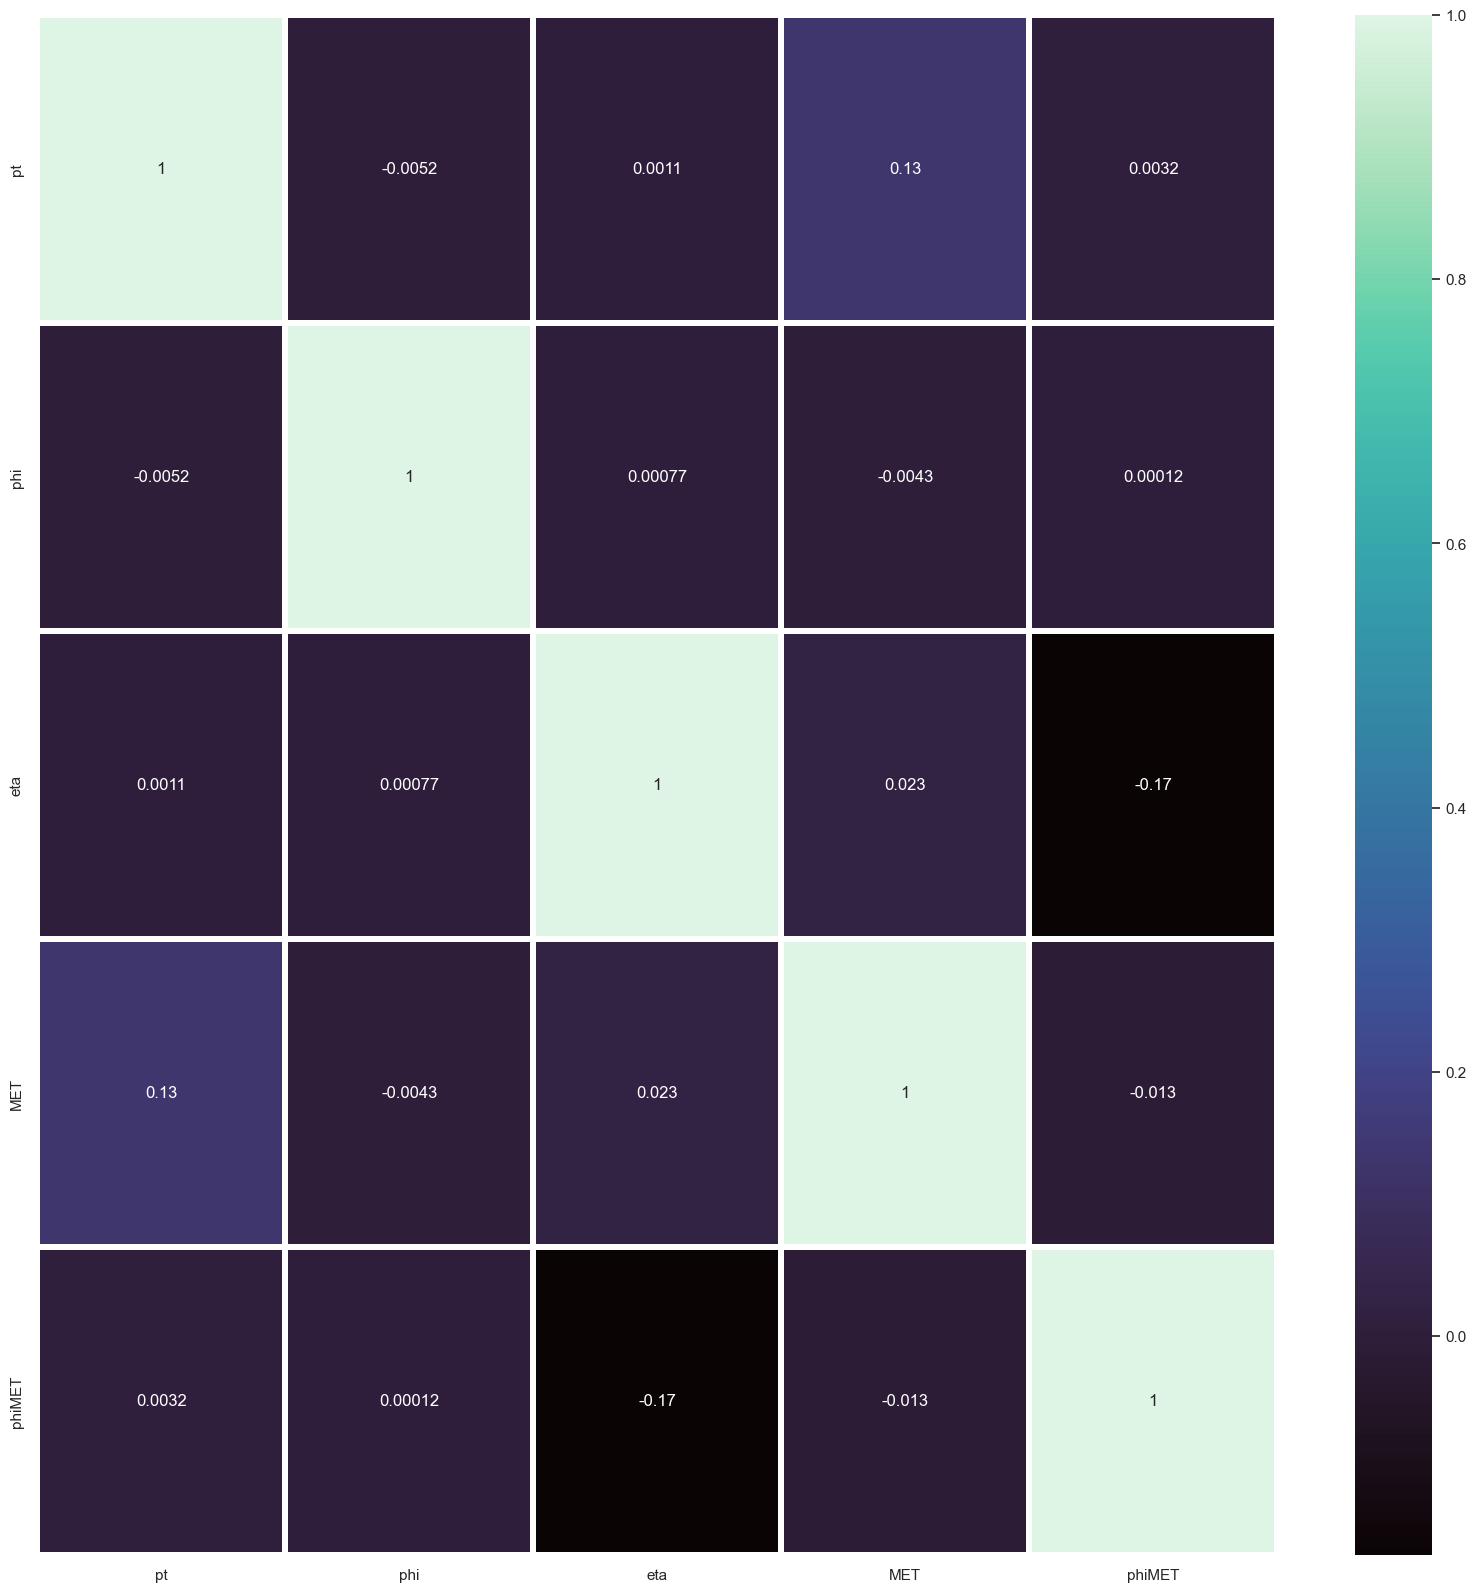

In [24]:
if data_checks=='y':
    fig, ax = plt.subplots(figsize=(20,20))
    sns.set(font_scale=1.0)
    sns.heatmap(dfmunu_array_to_dfmunu.corr() , annot= True, linewidths=3, ax=ax, cmap='mako')

**Heatmap comment**: no relevant (linear) correlations between the features manifest itself at this stage

<Figure size 2000x1000 with 0 Axes>

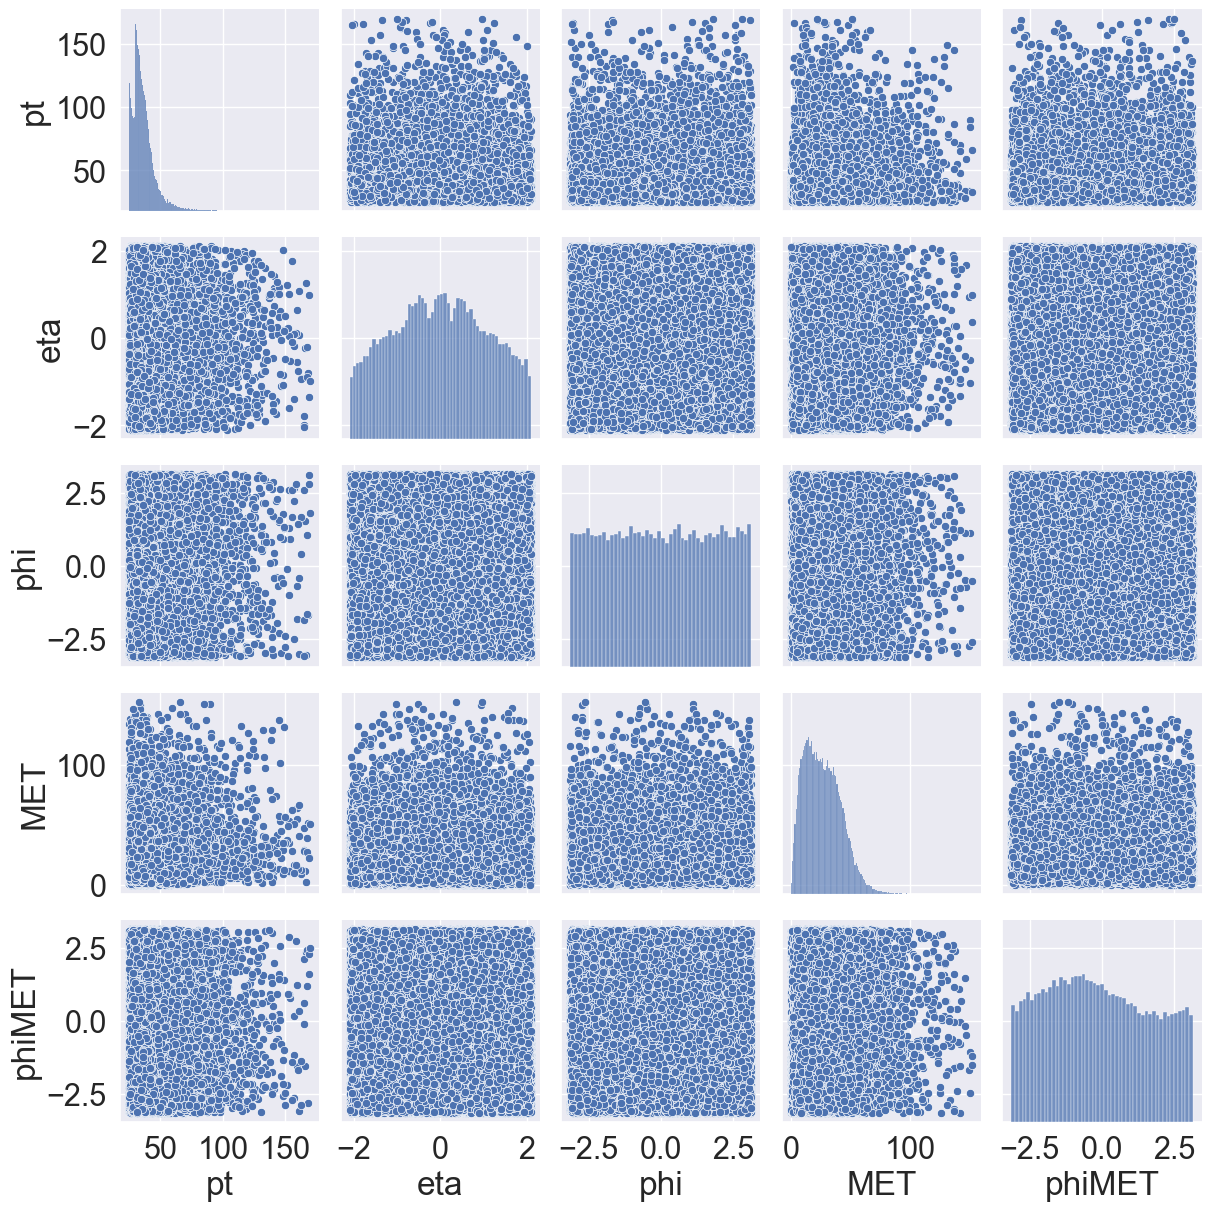

In [25]:
if data_checks=='y':
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    fig_pairplot_mu = sns.pairplot(dfmu) # diag_kind='kde'

In [ ]:
#fig_pairplot_mu.savefig('pairplot_munu.png')

In [8]:
# Adding 'class' because of dataset merging
class_col = []
for i in range(len(dfmu['pt'])):
    class_col.append('munu')
    
dfmu.loc[:,'class'] = class_col

/var/folders/2z/_ll869ld6fxbv3kk_q_mqkg80000gn/T/ipykernel_20999/1544916654.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmu.loc[:,'class'] = class_col


In [9]:
dfmu.sample(10)

,pt,eta,phi,MET,phiMET,class
40005,36.5763,0.2101,-2.5328,34.3101,-0.0662,munu
35248,49.7819,-0.6356,-1.5252,46.4795,1.4546,munu
56590,31.5872,-1.2956,-2.7388,34.1402,0.3140,munu
53874,49.3231,1.1064,2.0137,36.3699,2.5804,munu
77465,43.5867,-1.5011,2.9987,18.2273,-0.9184,munu
13289,30.7199,-1.6107,2.0101,25.4695,-0.7861,munu
85021,30.2747,1.2520,2.7201,9.8733,-0.5640,munu
85593,50.7300,-0.0905,0.2641,19.4205,-1.7017,munu
13801,35.0784,0.8293,1.5789,13.4088,-1.5148,munu
19614,29.7587,-0.3911,-2.8242,3.9109,-0.3896,munu


# Merging data

In [26]:
del dfenu_raw, dfmunu_raw # clean up

In [27]:
df = pd.concat([dfe,dfmu], ignore_index=True, sort=False)
#df.sample(5)

,pt,eta,phi,Q,iso,MET,phiMET,class
174237,39.4259,2.0263,0.5821,1,1.6398,31.4981,-2.8968,munu
106285,30.3852,1.6034,2.2973,1,40.2122,11.2884,0.9759,munu
95073,26.7642,0.6651,-1.4030,-1,7.9665,13.6150,0.0393,munu
110828,29.9760,0.3807,1.5187,1,91.5343,12.7908,-2.3137,munu
23683,59.2199,2.3391,-1.8215,1,18.7791,21.0457,1.5293,enu


In [28]:
del dfe, dfmu # clean up

## Data checks

In [29]:
if data_checks=='y':
    # Per verificare che il dataset sia bilanciato
    sns.countplot(data=df,x='class')

In [30]:
if data_checks=='y':
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    fig_pairplot = sns.pairplot(df, hue="class", palette="deep")
    fig_pairplot.savefig('pairplot_merged.png')

**Merged Pairplot**: questo ha un'ulteriore utilità pké nonostante io abbia verificato che nn ci sono dipendenze evidenti separatamente tra le features, potenzialmente potrebbero esserci modi semplici di classificare sla base di poche feature (magari lo scatter tra 2 feature separa nettamente le 2 classi e quindi il problema di classificazione è immediatamente risolto). Effettivamente nn sembrano esserci maniere evidenti di risolvere il problema di classificazione a mano

## Dataset splitting (train, validation, test)

In [31]:
# Map class to int
df['class'] = df['class'].map({'enu': 0, 'munu': 1})

In [32]:
# Split labels from data
X = df.drop(['class'], axis=1)
y = df['class']

del df

In [33]:
# Removing test data from training
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.20, random_state=0) # this outputs pandas
# random_state initialized to an int makes the shuffling reproducible (fixes the random seed)

In [34]:
# train-validation split
X_train, X_validation, y_train, y_validation = train_test_split(X_other, y_other, test_size=0.20, random_state=0) # this outputs pandas

## Feature engineering

**Standardizzazione** (0 mean and variance 1, but it's still a linear transformation, I'm not forcing the data to be normal!)

In [36]:
# Costruiamo il layer e informiamolo (ie ho solo 1 forma/STRUTTURA che adatto ai dati MA NN LO STO POPOLANDO!)
X_train_scaler = tf.keras.layers.Normalization(axis=-1) # axis=-1 gli dice come leggere il tensor ie in quale direz calcolare medie e varianze (qua banalmente se sle righe (axis=0) o sle colonne (axis=-1 o axis=1 fa li stès))
X_train_scaler.adapt(tf.convert_to_tensor(X_train)) # qua informiamo il layer sui dati, ie si calcola medie e varianze che userà poi

X_validation_scaler = tf.keras.layers.Normalization(axis=-1)
X_validation_scaler.adapt(tf.convert_to_tensor(X_validation))

X_test_scaler = tf.keras.layers.Normalization(axis=-1)
X_test_scaler.adapt(tf.convert_to_tensor(X_test))

# The MODEL

In [37]:
def my_model():
   model = tf.keras.Sequential([
    X_train_scaler,
    tf.keras.layers.Dense(28, activation=activation),
    tf.keras.layers.Dense(12, activation=activation),
  # tf.keras.layers.Dense(6, activation=activation),
    tf.keras.layers.Dense(12, activation=activation),
    tf.keras.layers.Dense(28, activation=activation),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)       
   ])
   model.compile(
                 optimizer=choosen_optimizer,
       # usiamo "Sparse" perché le classes nn sono rappresentate con one hot encoding ie (0,1) e (1,0) ma con interi ie 0 e 1
                 loss = choosen_loss,
                 metrics=['accuracy'])
 
   return model

model = my_model()

# Training

In [38]:
history = model.fit(X_train, y_train, epochs=nepochs, validation_data=(X_validation, y_validation), batch_size=100)

Epoch 1/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - accuracy: 0.5562 - loss: 0.6906 - val_accuracy: 0.6656 - val_loss: 0.5957
Epoch 2/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.6706 - loss: 0.5882 - val_accuracy: 0.6612 - val_loss: 0.5936
Epoch 3/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - accuracy: 0.6671 - loss: 0.5886 - val_accuracy: 0.6686 - val_loss: 0.5936
Epoch 4/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.6734 - loss: 0.5846 - val_accuracy: 0.6688 - val_loss: 0.5890
Epoch 5/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 573us/step - accuracy: 0.6734 - loss: 0.5811 - val_accuracy: 0.6817 - val_loss: 0.5769
Epoch 6/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6959 - loss: 0.5621 - val_accuracy: 0.7145 - val_loss: 0.5302
Epoch 7/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.7462 - loss: 0.5168 - val_accuracy: 0.7511 - val_loss: 0.5024
Epoch 8/100
1130/1130 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - accuracy: 0.

In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           348 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 28)             │           364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            58 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,201 (8.61 KB)

 Trainable params: 1,094 (4.27 KB)

 Non-trainable params: 11 (48.00 B)

 Optimizer params: 1,096 (4.29 KB)

## Performance check

1104/1104 - 0s - 323us/step - accuracy: 0.7689 - loss: 0.4503


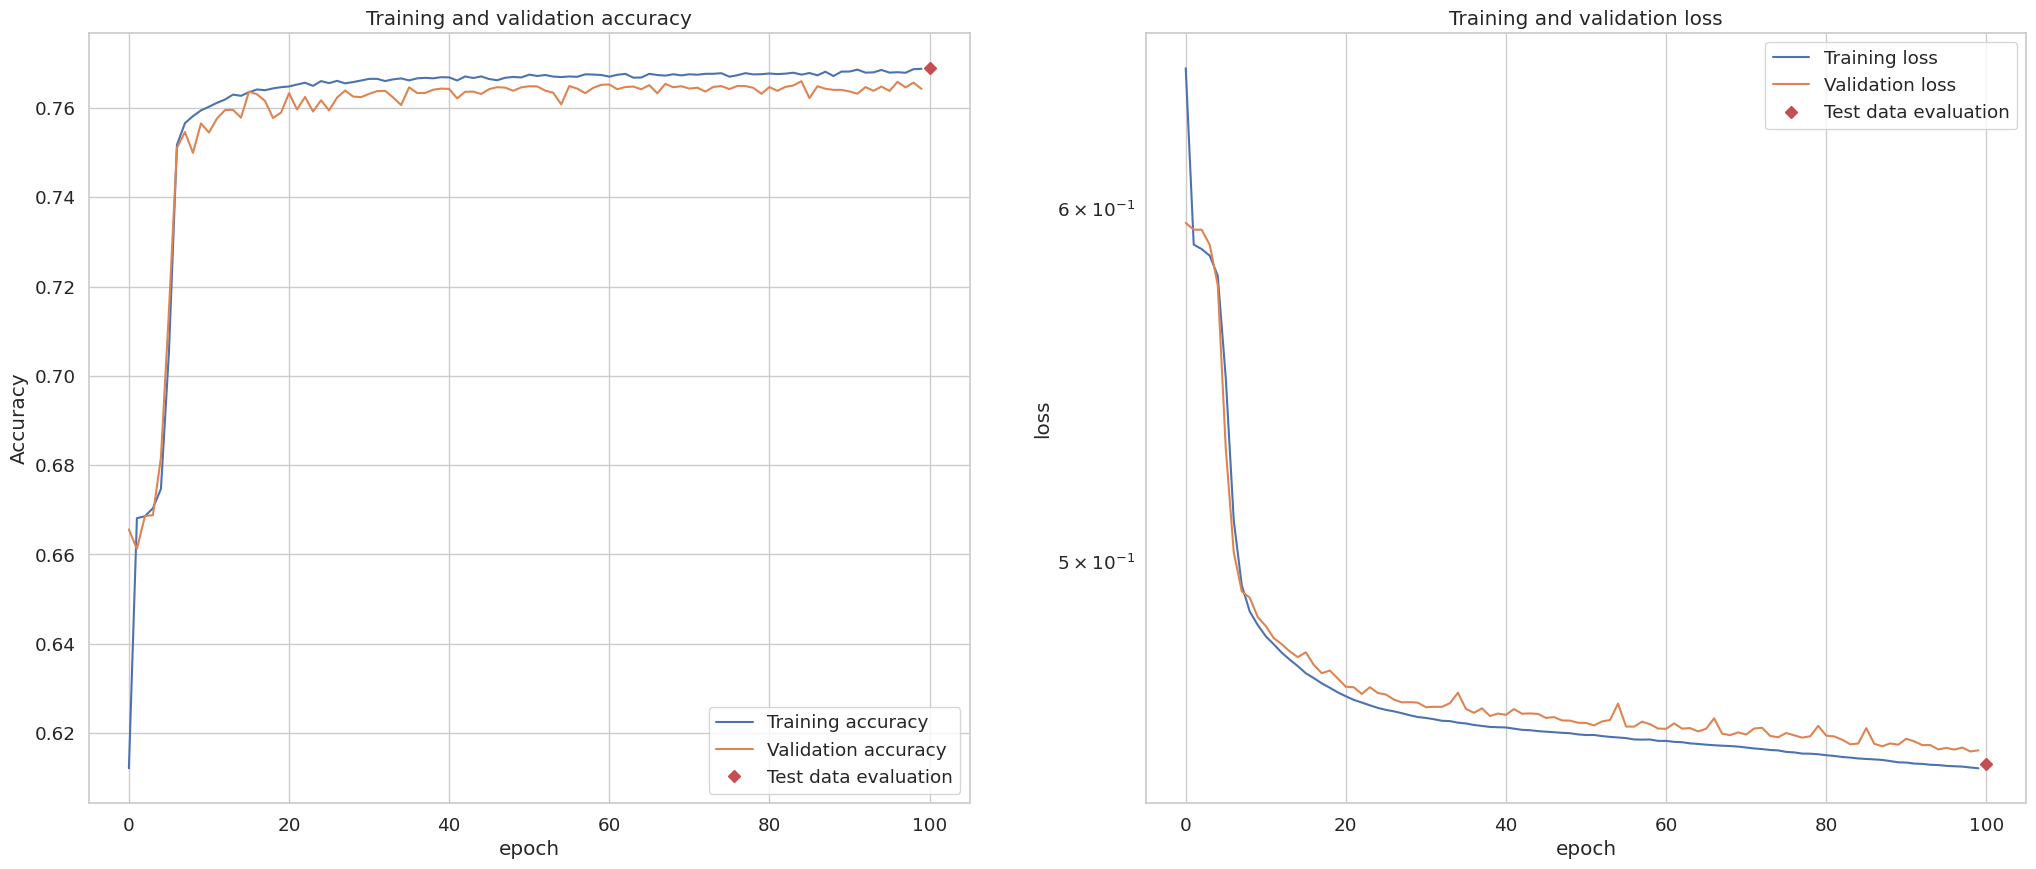

In [70]:
# aesthetics
font = {'family' : 'DejaVu Sans',
       'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig_rock_curve = plt.figure(figsize=(25,10))
ax1 = plt.subplot(121) # sta per 1,2,1 ie nrows, ncol, index
ax2 = plt.subplot(122)

# what to plot on first figure (ax1)
ax1.plot(history.history['accuracy'], label='Training accuracy') # qua specifico cosa plottare (le y, le x sono implicite in history)
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy') 

ax1.set_title("Training and validation accuracy")
ax1.set(xlabel='epoch', ylabel='Accuracy')

# what to plot on second figure (ax2)
ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')

ax2.set_title("Training and validation loss")
ax2.set(xlabel='epoch', ylabel='loss')
ax2.set_yscale('log')
ax2.grid('xy')

# testing
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
ax1.plot(nepochs, test_acc, 'rD', label="Test data evaluation")
ax2.plot(nepochs, test_loss, 'rD', label="Test data evaluation")

# Draw legend
ax1.legend(loc='lower right')
ax2.legend(loc='upper right')

In [61]:
fig_rock_curve.savefig('dummy.png')